In [127]:

import math
import numpy as np

from configobj import ConfigObj

from astropy.modeling.models import Moffat2D

import matplotlib.pyplot as plt

from astropy.coordinates import Angle
from astropy import units as u

In [31]:
def calculate_FWHM(wavelength,airmass):
    Config = ConfigObj('conf.ini')
    
    D = float(Config['Parameters']['telescope_diameter']) 
    L0 = float(Config['Parameters']['telescope_diameter'])
    median_seeing = float(Config['Seeing']['median_seeing'])
    median_seeing_wl = float(Config['Seeing']['median_seeing_wl'])
       
    r0=0.1*median_seeing**(-1)*(wavelength/median_seeing_wl)**1.2*airmass**(-0.6)  
    F_kolb=1/(1+300*(D/L0))-1
    
    FWHM_atm=median_seeing*airmass**(0.6)*(wavelength/median_seeing_wl)**(-0.2)*np.sqrt(1+F_kolb*2.183*(r0/L0)**0.356)
    FWHM_dl=0.000212*wavelength/D
    
    FWHM_total=np.sqrt(FWHM_atm**2+FWHM_dl**2)
    
    return FWHM_total

In [140]:
def make_moffat_PSFs(wavelengths,offsets,airmass,boundary,beta=2.5):
    
    wavelengths,offsets = np.array(wavelengths),np.array(offsets)
    Config = ConfigObj('conf.ini')
    scale = float(Config['Sim_Parameters']['scale'])
     
    boundary=math.ceil(boundary/2/scale) #radius of aperture in pixels

    FWHMs = calculate_FWHM(wavelengths,airmass)

    x = np.arange(-boundary, boundary+1)
    y = np.arange(-boundary, boundary+1)
    x, y = np.meshgrid(x, y)
          
    PSFs=np.zeros((len(wavelengths),boundary*2+1,boundary*2+1))
    total_vals=[]
    for count in range(0,len(wavelengths)):
        alpha=FWHMs[count]/scale/(2*np.sqrt(2**(1/beta)-1))
        x_pos=offsets[count][0]/scale  
        y_pos=offsets[count][0]/scale

        Moffat=Moffat2D(1,x_pos,y_pos,alpha,beta)
        Moffat_data=Moffat(x,y)
        
        PSFs[count]=Moffat_data
        
        moffat_total=(np.pi*alpha**2)/(beta-1)
        total_vals.append(moffat_total)
    
    return PSFs

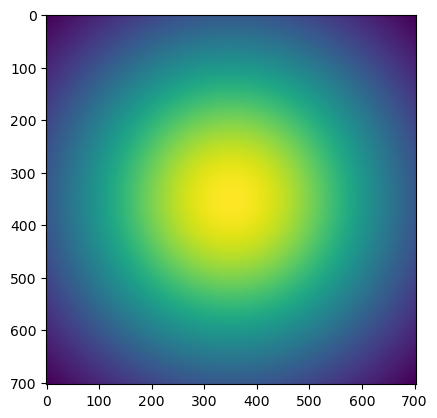

In [143]:
PSFs=make_moffat_PSFs([.3,.4,.5],[[0,.3],[0,0],[0,0]],1)
plt.imshow(PSFs[0])

#either PSFs generate perfectly, then crop and x by aperutre
#or offset straight away

In [ ]:
def parallatic_angle(HA,dec,lat):
    HA=Angle(HA*u.hour).rad
    q = np.arctan2(np.sin(HA),(np.cos(dec)*np.tan(lat)-np.sin(dec)*np.cos(HA)))
    return q